In [2]:
# SCREAM as example for paper figures
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
from scipy import stats
from utility import analysis_parameters as ap
from matplotlib.gridspec import GridSpec

import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

model="SCREAM"
region="TWP"
chunks={"ncol":1200}

In [3]:
# TWP plots
## 1. vertical profiles of RH, temperature, and IWC in height and temperature vertical coordinates
## 2. streamfunction with CRH
## 3. CRH/IWP percentiles with cloud fraction/IWC
## 4. ice number content in IWP space
## 5. get cloud base height/temp and cloud top height/temp
## plot histogram of cld base/top height/temp
## histogram of cld base when cirrus are present
## flag columns with cirrus only 
## 6. for TTL cirrus, histograms of cloud base height/temp
## and relative humidity correlation with in/above cloud


In [4]:
# functions
def get_esi(t):
    return (611.21 * np.exp(22.587*t/(t+273.86)))

def get_es(t):
    return (610.94 * np.exp(17.625*t/(t+243.04)))

def get_qs(es, p):
    return 0.622*es/p

def q2rhi(t, p, q, **kwargs):
    """
    Returns xarray of relative humidity wrt ice
    rhi = q/qs*100
    qsi = 0.622*es/P
    esi = 611.21 exp(22.587*T/(T+273.86)) for T <  0C
    """
    t = t - 273.15 # convert to deg C
    esi = get_esi(t)
    qsi = get_qs(esi, p)
    rh = q/qsi * 100
    return rh

def q2rh(t, p, q, **kwargs):
    """
    Returns xarray of relative humidity wrt liquid
    rh = q/qs*100
    qs = 0.622*es/P
    es = 610.94 exp(17.625*T/(T+243.04)) for T >= 0C
    """
    t = t - 273.15 # convert to deg C
    es = get_es(t)
    qs = get_qs(es, p)
    rh = q/qs * 100
    return rh

def q2wc(t, p, q, qi, **kwargs):
    """
    Returns xarray of ice or liquid water content
    iwc = qi * rho
    """
    rho = calc_rho(t, p, q)
    return (qi*rho)
    
def pot_temp(t, p):
    """ Returns potential temperature (theta in K)
        Input t (K) and p (Pa)
    """
    Rd = 287 # J/K/kg
    cp = 1004 # J/K/kg
    theta = t * np.power(100000/p, Rd/cp)
    return theta

def eq_pot_temp(t, p, q):
    """ Returns equivalent potential temperature (thetae in K)
        Input t (K), p (Pa) and q (kg/kg)
    """
    theta = pot_temp(t,p)
    Lv = 2.25e6 # J/kg
    cp = 1004 # J/K/kg
    qsi = get_qsi(get_esi(t), p)
    thetae = theta * np.exp(Lv * qsi / (cp * t) )
    return thetae
    
def crh_percentiles(t, p, q, lev="lev", bins = np.arange(0,101,4), return_crh=False):
    """
    Integreate column realitive humidity then bin by percentiles.
    Bins are 0-100 by 1s. Returns bin edges and crh_percentiles as
    mid_bin values. 
    
    Returns: bins, crh_percs
        if return_crh is True, returns (crh, (bins, crh_percs))
        
    TODO: crh = column integrated wv to saturatation wv
    """
    qs = get_qs(get_es(t), p)
    q_int = q.integrate("lev")
    qs_int = qs.integrate("lev")
    crh = q_int/qs_int
    print("shape of crh:", crh.shape)
    crh_percs = np.zeros(crh.shape)
    
    for i in range(len(bins)-1):
        perc_thres_lower = np.nanpercentile(crh, bins[i])
        perc_thres_upper = np.nanpercentile(crh, bins[i+1])
        crh_percs = np.where((crh>=perc_thres_lower)&(crh<perc_thres_upper), 
                             (bins[i]+bins[i+1])/2, crh_percs)
    crh_percs = xr.DataArray(crh_percs, dims=crh.dims, coords=crh.coords, 
                             attrs={"long_name":"column relative humidity binned percentiles","units":"%"})
    if return_crh:
        return crh, (bins, crh_percs)
    else:
        return bins, crh_percs
    return bins, crh_percs

def stream_function(omega, crh_perc, bins, return_omega=False):
    """
    Calculate the mean profiles for given omega (Pa/s)
    for each CRH percentile bin.
    
    Input:  vertical velocity (omega, unit: Pa/s),  
            column relative humidity percentiles (crh_perc, unit: %),
            bin edges (bins, unit: %) same as from crh_percentiles.
            
    Output: stream function (phi_rp) in coordinates of CRH and pressure.
                should be of shape (100, nlevs)
            if return_omega is True, returns (w_rp, phi_rp) as tuple
            
    """
    w_rp   = np.zeros((len(bins)-1, omega.shape[1])) # shape of crh mid_bins and pres levels
    phi_rp = np.zeros((len(bins)-1, omega.shape[1])) # shape of crh mid_bins and pres levels
    for i in range(20, len(bins)-1):
        w_rp[i,:] = omega.where((crh_perc>= bins[i])&(crh_perc<bins[i+1])).mean(skipna=True, dim=["time","ncol"])
        alpha = 1 # 0.01
        if (i==20):
            phi_rp[i,:] = alpha/9.8*w_rp[i,:]
        else:
            phi_rp[i,:] = phi_rp[i-1]+ alpha/9.8*w_rp[i,:] 
    if return_omega:
        return phi_rp, w_rp
    return phi_rp

def binned_by_crh(var, crh_perc, bins):
    """
    Calculate the mean profiles for given variable
    for each CRH percentile bin.
    
    Input:  variable (e.g., qi, unit: kg/kg),  
            column relative humidity percentiles (crh_perc, unit: %),
            bin edges (bins, unit: %) same as from crh_percentiles.
            
    Output: binned_var (var_r) in coordinates of CRH and pressure.
                should be of shape (100, nlevs)
            
    """
    var_r = np.zeros((len(bins)-1, var.shape[1])) # shape of crh mid_bins and pres levels
    for i in range(len(bins)-1):
        var_r[i,:] = var.where((crh_perc>= bins[i])&(crh_perc<bins[i+1])).mean(skipna=True, dim=["time","ncol"])
    return var_r

def calc_rho(t, p, q):
    Tv = (1 + 0.61*q)*t
    rho = p / (287*Tv)
    return rho

def w2omega(t, p, q, w):
    rho = calc_rho(t, p, q)
    g=9.8 #m/s2
    omega = -rho*g*w # (kg/m/s2)/s = Pa/s
    return omega

def omega2w(t, p, q, omega):
    rho = calc_rho(t, p, q)
    g=9.8
    w = -omega/(rho*g) # m/s
    return w

In [5]:
# load temp, wv, pres, and height
ndays=3
t = xr.open_dataset(ap.get_file(model, region+"_3D", "ta"), 
                    chunks=chunks).isel(time=slice(-8*ndays,-1)).ta
p = t.lev*100 # convert to Pa
q = xr.open_dataset(ap.get_file(model, region+"_3D", "hus"), 
                    chunks=chunks).isel(time=slice(-8*ndays,-1)).hus

z = xr.open_dataset(ap.get_file(model, region+"_3D", "zg"), 
                    chunks=chunks).isel(time=slice(-8*ndays,-1)).zg
z_plot = z.mean(axis=(0,2))
qi = xr.open_dataset(ap.get_file(model, region+"_3D", "cli"), 
                    chunks=chunks).isel(time=slice(-8*ndays,-1)).cli

# match z shape
t = t[:,1:]
q = q[:,1:]
p = p[1:]
qi = qi[:,1:]

In [5]:
# calculate RH and qi then bin wrt temperature
rhi = q2rhi(t, p, q)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [6]:
rhi = rhi.compute()

[########################################] | 100% Completed |  2.9s


[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  1.8s


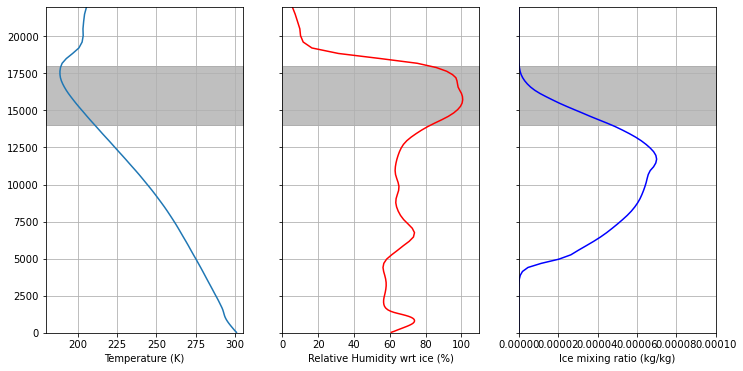

In [7]:
# plot temperature, relative humidity, and cloud ice in height coordinates

fig, ax = plt.subplots(1,3, figsize=(12,6), sharey=True)
ax[0].plot(t.mean(axis=(0,2)), z_plot)
ax[1].plot(rhi.mean(axis=(0,2)), z_plot, label="rh", color="red")
ax[2].plot(qi.mean(axis=(0,2)), z_plot, label="qi", color="blue")
xlims = [(180,305),(0,110),(0,1e-4)]
xlabels= ["Temperature (K)", "Relative Humidity wrt ice (%)", "Ice mixing ratio (kg/kg)"]
for i in range(3):
    ax[i].fill_between(xlims[i],14000,18000, color='gray', alpha=0.5)
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_xlim(xlims[i])
    ax[i].set_ylim([0,22000])
    ax[i].grid(True)
# plt.savefig("../plots/{}_{}_last{}days_t-rhi-qi.png".format(region, model, ndays))
plt.show()

[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.4s


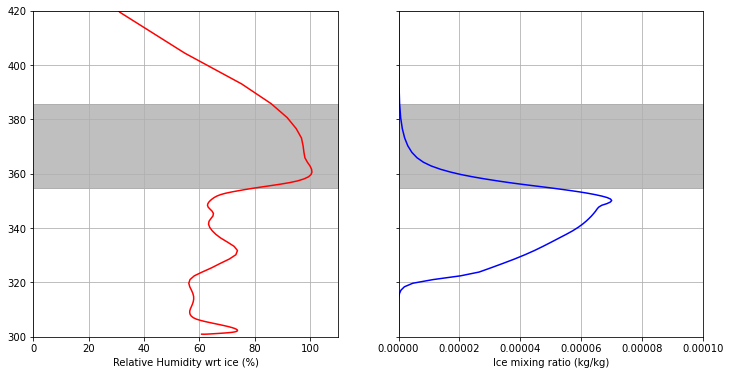

In [8]:
# plot relative humidity and cloud ice in temperature coordinates
theta = pot_temp(t, p).mean(axis=(0,2)).values

fig, ax = plt.subplots(1,2, figsize=(12,6), sharey=True)
ax[0].plot(rhi.mean(axis=(0,2)), theta, label="rh", color="red")
ax[1].plot(qi.mean(axis=(0,2)), theta, label="qi", color="blue")
xlims = [(0,110),(0,1e-4)]
xlabels= ["Relative Humidity wrt ice (%)", "Ice mixing ratio (kg/kg)"]
for i in range(2):
    ax[i].fill_between(xlims[i],theta[np.argmin(abs(z_plot.values-14000))],theta[np.argmin(abs(z_plot.values-18000))], color='gray', alpha=0.5)
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_xlim(xlims[i])
    ax[i].set_ylim([300,420])
    ax[i].grid(True)
# plt.savefig("../plots/{}_{}_last{}days_theta-rhi-qi.png".format(region, model, ndays))
plt.show()

In [39]:
# stream function
# calculate crh percentiles
bins, crh_percs = crh_percentiles(t, p, q)
omega = xr.open_dataset(ap.get_file(model, region+"_3D", "wap")).isel(time=slice(-8*ndays,-1)).wap
omega = omega[:,1:]
print(omega.shape)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
shape of crh: (23, 61250)
[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.9s
[#####################

In [10]:
# calculate stream function, phi
phi = stream_function(omega, crh_percs, bins)

In [11]:
# bin rhi by column relative humidity
rhi_r = binned_by_crh(rhi, crh_percs, bins)

[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s


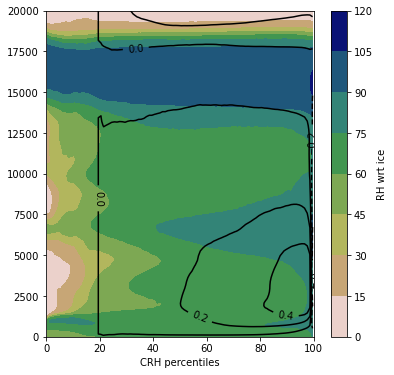

In [16]:
# plot stream function in black contours with rhi in colormap
# all binned by column relative humidity
fig, ax = plt.subplots(1,1, figsize=(6,6))
bin_mid = (bins[:-1]+bins[1:])/2
pc = ax.contour(bin_mid, z_plot, phi.T, colors="k", levels=6)
pci = ax.contourf(bin_mid, z_plot, rhi_r.T, cmap="gist_earth_r")
ax.set_ylim([0, 20000])
# ax.fill_between([0, 100], 14000, 18000, color='gray', alpha=0.5)
ax.set_xlim([0,100])
ax.set_xlabel("CRH percentiles")
plt.colorbar(pci, ax=ax, label="RH wrt ice")
ax.clabel(pc, pc.levels, inline=True, fontsize=10)
plt.savefig("../plots/{}_{}_streamfunction-qi.png".format(region, model))
plt.show()

In [6]:
# load iwp, olr and albedo
iwp = xr.open_dataset(ap.get_file(model, region, "clivi")).isel(time=slice(-8*ndays,-1)).clivi
iwp_expand = iwp.expand_dims({"lev":127},axis=1)
olr = ap.load_olr(model, region).isel(time=slice(-8*ndays,-1))
alb = ap.load_alb(model, region).isel(time=slice(-8*ndays,-1))
# lwp = xr.open_dataset(ap.get_file(model, region, "clwvi")).isel(time=slice(-8*ndays,-1))
qi = xr.open_dataset(ap.get_file(model, region+"_3D", "cli")).isel(time=slice(-8*ndays,-1)).cli[:,1:]
ql = xr.open_dataset(ap.get_file(model, region+"_3D", "clw")).isel(time=slice(-8*ndays,-1)).clw[:,1:]
icenvi = xr.open_dataset(ap.get_file(model, region+"_3D", "icenvi")).isel(time=slice(-8*ndays,-1)).icenvi
print(olr.shape, alb.shape, qi.shape, ql.shape, icenvi.shape)

[########################################] | 100% Completed |  0.7s
(23, 61250) (23, 61250) (23, 127, 61250) (23, 127, 61250) (23, 61250)


In [7]:
iwc = q2wc(t, p, q, qi)
lwc = q2wc(t, p, q, ql)
del qi, ql
twc = iwc + lwc
del iwc, lwc

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [14]:
# calculate iwp percentiles
# may as well bin rhi by iwp right now too
bins = np.arange(0,100.1,4)
iwp_percs = np.zeros(iwp.shape)
twc_iwp = np.zeros((len(bins)-1, twc.shape[1]))
olr_iwp = np.zeros(len(bins)-1)
alb_iwp = np.zeros(len(bins)-1)
icenvi_iwp = np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    print(i)
    perc_thres_lower = np.nanpercentile(iwp, bins[i])
    perc_thres_upper = np.nanpercentile(iwp, bins[i+1])
    iwp_percs = np.where((iwp>=perc_thres_lower)&(iwp<perc_thres_upper), 
                         (bins[i]+bins[i+1])/2, iwp_percs)
    twc_iwp[i,:] = twc.where((iwp_expand>=perc_thres_lower)&(iwp_expand<perc_thres_upper)).mean(skipna=True, axis=(0,2))
    olr_iwp[i] = np.nanmean(np.where((iwp>=perc_thres_lower)&(iwp<perc_thres_upper), 
                                     olr, np.nan))
    alb_iwp[i] = np.nanmean(np.where((iwp>=perc_thres_lower)&(iwp<perc_thres_upper), 
                                     alb, np.nan))
    icenvi_iwp[i] = np.nanmean(np.where((iwp>=perc_thres_lower)&(iwp<perc_thres_upper), 
                                     icenvi, np.nan))

0
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.4s
1
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
2
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
3
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
4
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  0.1s
[#####################################

In [15]:
# plot iwc in iwp space 
# along with olr and albedo
# next, plot ice crystal number amount in iwp space


[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.2s


/tmp/ipykernel_2158120/453940083.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  pci = ax[0].contourf(bin_mid, z_plot, (twc_iwp.T)*1000, levs, cmap="gist_earth_r", norm=colors.LogNorm()) # locator=ticker.LogLocator()


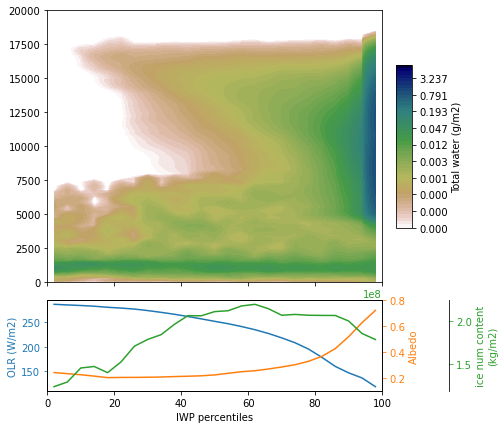

In [18]:
# plot IWC in iwp space 
fig, ax = plt.subplots(2,1, figsize=(6,7), sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace':0.1})
bin_mid = (bins[:-1]+bins[1:])/2
## axis 0 - iwc in iwp space
levs = np.logspace(-5,1)
pci = ax[0].contourf(bin_mid, z_plot, (twc_iwp.T)*1000, levs, cmap="gist_earth_r", norm=colors.LogNorm()) # locator=ticker.LogLocator()
ax[0].set(ylim=[0, 20000], xlim=[0,100])
cax = ax[0].inset_axes([1.04, 0.2, 0.05, 0.6])
plt.colorbar(pci, cax=cax, label="Total water (g/m2)", shrink=0.5)
## axis 1 - mean olr,alb,lwp in iwp space 
ax[1].plot(bin_mid, olr_iwp, color="C0", label="OLR")
ax[1].set(xlabel="IWP percentiles", ylabel="OLR (W/m2)")
ax[1].yaxis.label.set_color("C0")
ax[1].tick_params(axis='y', colors="C0")
axt = ax[1].twinx()
axt.plot(bin_mid, alb_iwp, color="C1", label="albedo")
axt.set(ylabel="Albedo", ylim=[0.1,0.8])
axt.yaxis.label.set_color("C1")
axt.tick_params(axis='y', colors="C1")
axn = ax[1].twinx()
axn.spines.right.set_position(("axes", 1.2))
axn.plot(bin_mid, icenvi_iwp, color="C2", label="ice num")
axn.set(ylabel="ice num content\n(kg/m2)")
axn.yaxis.label.set_color("C2")
axn.tick_params(axis='y', colors="C2")

plt.savefig("../plots/{}_{}_iwc_iwp-space.png".format(region, model), bbox_inches="tight", pad_inches=1)
plt.show()

In [1]:
## get cloud top height and temperature
twc_cumsum = twc.cumsum(axis=1, skipna=True) # top down
print(twc_cumsum.shape)
iwc_small = 1e-5 #kg/m3
ind = abs(twc_cumsum-iwc_small).argmin(axis=1)
print(ind.shape)
# cth = z.isel(lev=ind)
# print(cth.shape)
# ctt[:,l] = t.isel(lev=ind)

NameError: name 'twc' is not defined